# Ouverture du fichier
Vous pouvez cloner le fichier par contre il faudra que vous ajoutiez le fichier challenge_set.json qui est trop volumineux pour github. Celui-ci se trouve dans le dossier `spotify_million_playlist_dataset_` qui lui même est donné en suivant les liens qui se trouvent dans les consignes. Une fois que vous avez mis ce fichier dans votre dossier avec le code tout devrait run sans problème
Faites un `Ctrl+F` avec "ici" pour trouver tous les endroits où il y a un petit bug ou une optimisation à faire.  

---
## Division du projet en plusieurs partie:
- Stat descriptive
- Construction de la DB
- Similarité entre musique
- Similarité entre playlist
- Lda



In [ ]:
#pip install "dask[complete]"
import pandas as pd
import numpy as np
import sys
import json
import glob
import os
import math
import dask.dataframe as dd
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import pyarrow.parquet as pq
import pyarrow as pa
import heapq
import shutil
from collections import defaultdict


In [3]:
json_folder = os.path.join(sys.path[0], "data_json")

# cree le dossier parquet pour les albums
parquet_folder = os.path.join(sys.path[0], "data_parquet")
os.makedirs(parquet_folder, exist_ok=True)

# cree le dossier parquet pour les tracks
parquet_folder_tracks = os.path.join(sys.path[0], "data_tracks_parquet")
os.makedirs(parquet_folder_tracks, exist_ok=True)

json_files = glob.glob(os.path.join(json_folder, "*.json"))
print(f"Nombre de fichiers trouvés : {len(json_files)}")

for file in json_files:
    #print(f"Conversion de {file}...")
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)              # charge le gros dictionnaire
        playlists = data["playlists"]    # extrait la liste des playlists

    # Partie sur les albums, rempli parquet
    df = pd.json_normalize(playlists)
    base_name = os.path.basename(file).replace(".json", ".parquet")
    parquet_path = os.path.join(parquet_folder, base_name)
    df.to_parquet(parquet_path, engine="pyarrow", index=False)

    rows = []
    for pl in playlists:
        pid = pl["pid"]
        for track in pl["tracks"]:
            track["pid"] = pid   # garder l’ID de la playlist
            rows.append(track)

    df_tracks = pd.DataFrame(rows)
    
    for i in ("track", "artist", "album"):
        uri_col = i + "_uri"
        id_col = i + "_id"
        if uri_col in df_tracks.columns:
            df_tracks[id_col] = df_tracks[uri_col].str.split(":").str[-1]
            df_tracks.drop(columns=[uri_col], inplace=True)

    # Sauvegarder en Parquet
    parquet_track_path = os.path.join(parquet_folder_tracks, base_name)
    df_tracks.to_parquet(parquet_track_path, engine="pyarrow", index=False)

print("Data sur les albums")
df = dd.read_parquet(parquet_folder)
print(df.head())
print("Data sur les tracks")
df_tracks = dd.read_parquet(parquet_folder_tracks)
print(df_tracks.head())
print(df_tracks.columns)


Nombre de fichiers trouvés : 1000


You can run directly thoses lines if parqueets folder already exists

In [2]:
parquet_folder = os.path.join(sys.path[0], "data_parquet")
parquet_folder_tracks = os.path.join(sys.path[0], "data_tracks_parquet")
df_playlists = dd.read_parquet(parquet_folder)
df_tracks = dd.read_parquet(parquet_folder_tracks)
df = 0

# Stat descriptive

In [ ]:
nb_playlists = df_playlists["pid"].nunique().compute()
nb_tracks_total = len(df_tracks)  
nb_tracks_uniques = df_tracks["track_uri"].nunique().compute()
nb_artists_uniques = df_tracks["artist_name"].nunique().compute()

print("General overview:")
print("Total number of playlists:", nb_playlists)
print("Total number of tracks:", nb_tracks_total)
print("Number of unique tracks:", nb_tracks_uniques)
print("Number of unique artists:", nb_artists_uniques)

General overview:
Total number of playlists: 1000000
Total number of tracks: 66346428
Number of unique tracks: 2262292
Number of unique artists: 287742


In [ ]:
import dask.dataframe as dd
import os

parquet_folder = r"C:\Users\stag_compta\Documents\datasets\1\data_parquet"
track_files = [os.path.join(parquet_folder, f) for f in os.listdir(parquet_folder) if f.endswith("_tracks.parquet")]
df_tracks = dd.read_parquet(track_files, engine="pyarrow")

# --- Number of tracks per playlist ---
tracks_per_playlist = df_tracks.groupby("pid")["track_uri"].count().compute()

# --- Total duration per playlist (convert ms → minutes) ---
duration_per_playlist = (df_tracks.groupby("pid")["duration_ms"].sum().compute() / 60000)

# --- Descriptive statistics ---
print("\nPlaylist Structure:")
print("Tracks per playlist:")
print("Mean:", round(tracks_per_playlist.mean(), 1))
print("Median:", round(tracks_per_playlist.median(), 1))
print("Min:", int(tracks_per_playlist.min()))
print("Max:", int(tracks_per_playlist.max()))

print("\nDuration per playlist (minutes):")
print("Mean:", round(duration_per_playlist.mean(), 1))
print("Median:", round(duration_per_playlist.median(), 1))
print("Min:", round(duration_per_playlist.min(), 1))
print("Max:", round(duration_per_playlist.max(), 1))



Playlist Structure:
Tracks per playlist:
Mean: 66.3
Median: 49.0
Min: 5
Max: 376

Duration per playlist (minutes):
Mean: 259.7
Median: 190.4
Min: 1.6
Max: 10584.6


In [23]:
nb_playlists = df_playlists["pid"].nunique().compute()
nb_tracks_total = len(df_tracks)  # nombre total de lignes = tracks
nb_tracks_uniques = df_tracks["track_id"].nunique().compute()
nb_artists_uniques = df_tracks["artist_name"].nunique().compute()
avg_tracks = df_playlists["num_tracks"].mean().compute()
avg_albums = df_playlists["num_albums"].mean().compute()
avg_artists = df_playlists["num_artists"].mean().compute()

print("General overview:")
print("Total number of playlists:", format(nb_playlists, ".2e"))
print("Total number of tracks:", format(nb_tracks_total, ".2e"))
print("Number of unique tracks:", format(nb_tracks_uniques, ".2e"))
print("Number of unique artists:", format(nb_artists_uniques, ".2e"))
print("Average number of tracks per playlist:", int(round(avg_tracks)))
print("Average number of albums per playlist:", int(round(avg_albums)))
print("Average number of artists per playlist:", int(round(avg_artists)))

def sci_format(x, sig=3):
    if x == 0:
        return "0"

    # exposant multiple de 3
    exp = int(np.floor(np.log10(abs(x)) // 3 * 3))
    # coefficient
    coef = x / (10**exp)
    # arrondir le coefficient à sig chiffres significatifs
    # on calcule le nombre de décimales nécessaires
    decimals = sig - int(np.floor(np.log10(abs(coef))) + 1)
    coef_rounded = round(coef, max(decimals, 0))
    
    return f"{coef_rounded} × 10^{exp}"

# Descriptive statistics for number of tracks/album/artist per playlist
stats_tracks = df_playlists["num_tracks"].describe().compute()
stats_albums = df_playlists["num_albums"].describe().compute()
stats_artists = df_playlists["num_artists"].describe().compute()

print("\nDescriptive statistics - Tracks per playlist:\n", stats_tracks.apply(sci_format))
print("\nDescriptive statistics - Albums per playlist:\n", stats_albums.apply(sci_format))
print("\nDescriptive statistics - Artists per playlist:\n", stats_artists.apply(sci_format))



General overview:
Total number of playlists: 1.00e+06
Total number of tracks: 6.63e+07
Number of unique tracks: 2.26e+06
Number of unique artists: 2.88e+05
Average number of tracks per playlist: 66
Average number of albums per playlist: 50
Average number of artists per playlist: 38

Descriptive statistics - Tracks per playlist:
 count      1.0 × 10^6
mean      66.3 × 10^0
std       53.7 × 10^0
min        5.0 × 10^0
25%       27.0 × 10^0
50%       51.0 × 10^0
75%       94.0 × 10^0
max      376.0 × 10^0
Name: num_tracks, dtype: object

Descriptive statistics - Albums per playlist:
 count      1.0 × 10^6
mean      49.6 × 10^0
std       40.0 × 10^0
min        2.0 × 10^0
25%       21.0 × 10^0
50%       38.0 × 10^0
75%       69.0 × 10^0
max      244.0 × 10^0
Name: num_albums, dtype: object

Descriptive statistics - Artists per playlist:
 count      1.0 × 10^6
mean      38.1 × 10^0
std       30.3 × 10^0
min        3.0 × 10^0
25%       16.0 × 10^0
50%       30.0 × 10^0
75%       53.0 × 10^0
ma

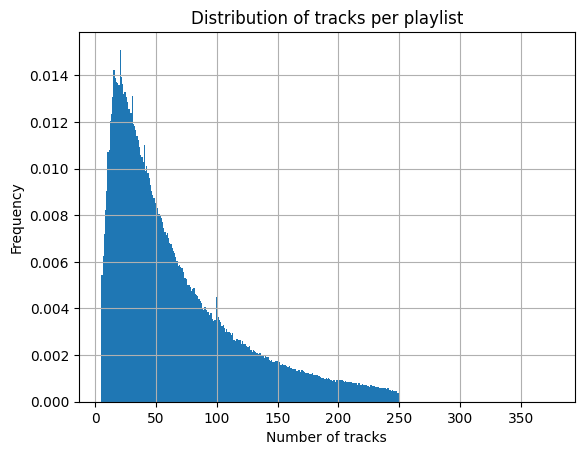

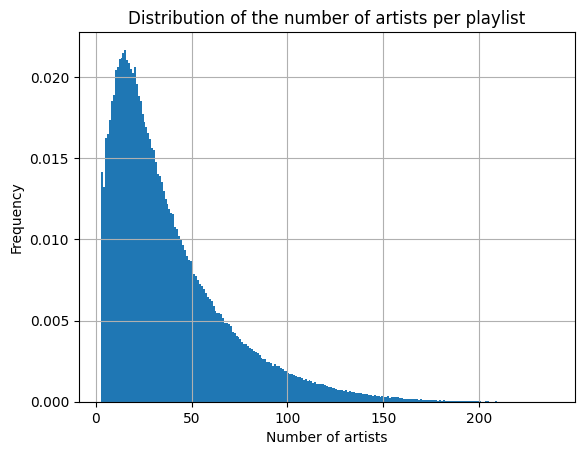

In [ ]:
num_tracks = df_playlists["num_tracks"].compute()
max_tracks = num_tracks.max()
min_tracks = num_tracks.min()
num_tracks.hist(bins=(max_tracks - min_tracks + 1), density=True)
plt.xlabel("Number of tracks")
plt.ylabel("Frequency")
plt.title("Distribution of tracks per playlist")
plt.show()


# Histogram of the number of artists per playlist
num_artists = df_playlists["num_artists"].compute()
max_artists = num_artists.max()
min_artists = num_artists.min()
num_artists.hist(bins=(max_artists -min_artists), density=True )
plt.title("Distribution of the number of artists per playlist")
plt.xlabel("Number of artists")
plt.ylabel("Frequency")
plt.show()

In [19]:
# Top 10 most frequent tracks
top_tracks = (
    df_tracks.groupby(["track_id", "track_name"])
             .size()       # nombre d'apparitions
             .compute()
             .reset_index(name="count")
             .sort_values("count", ascending=False)
             .head(10)
)
# Top 10 most frequent artists
top_artists = df_tracks["artist_name"].value_counts().nlargest(10).compute()

print("Top 10 most frequent tracks:")
print(top_tracks)
print("Top 10 most frequent artists:")
print(top_artists)

Top 10 most frequent tracks:
                       track_id                           track_name  count
1680379  7KXjTSCq5nL1LoYtL7XAwS                              HUMBLE.  46574
1605700  1xznGGDReH1oQq0xzbwXa3                            One Dance  43447
222493   7yyRTcZmCiyzzJlNzGC9Ol          Broccoli (feat. Lil Yachty)  41309
1607665  7BKLCZ1jbUBVqRi2FVlTVw                               Closer  41079
147942   3a1lNhkSLSkpJE4MSHpDu9                      Congratulations  39987
1752943  5hTpBe8h35rJ67eAWHQsJx                             Caroline  35202
1313626  2EEeOnHehOozLq4aS0n6SL              iSpy (feat. Lil Yachty)  35138
1168089  4Km5HrUvYTaSUfiSGPJeQR  Bad and Boujee (feat. Lil Uzi Vert)  34999
222287   7GX5flRQZVHRAGd6B4TmDO                        XO TOUR Llif3  34922
1605368  152lZdxL1OR0ZMW6KquMif                             Location  34657
Top 10 most frequent artists:
artist_name
Drake             847160
Kanye West        413297
Kendrick Lamar    353624
Rihanna           

In [20]:
# Descriptive statistics
stats_tracks = df_playlists["num_tracks"].describe().compute()
stats_duration = (df_playlists["duration_ms"] / 60000).describe().compute()  # minutes

print("\nPlaylists:")
print("Distribution of the number of tracks per playlist:")
print(stats_tracks.apply(sci_format))
print("\nDistribution of the total duration of playlists (minutes):")
print(stats_duration.apply(sci_format))



Playlists:
Distribution of the number of tracks per playlist:
count      1.0 × 10^6
mean      66.3 × 10^0
std       53.7 × 10^0
min        5.0 × 10^0
25%       27.0 × 10^0
50%       51.0 × 10^0
75%       94.0 × 10^0
max      376.0 × 10^0
Name: num_tracks, dtype: object

Distribution of the total duration of playlists (minutes):
count      1.0 × 10^6
mean     260.0 × 10^0
std      214.0 × 10^0
min       1.63 × 10^0
25%      105.0 × 10^0
50%      197.0 × 10^0
75%      367.0 × 10^0
max       10.6 × 10^3
Name: duration_ms, dtype: object


In [26]:
# Diversity
stats_artists = df_playlists["num_artists"].describe().compute()
stats_albums = df_playlists["num_albums"].describe().compute()

print("Diversity:")
print("Number of artists per playlist:")
print(stats_artists.apply(sci_format))
print("Number of albums per playlist:")
print(stats_albums.apply(sci_format))

Diversity:
Number of artists per playlist:
count      1.0 × 10^6
mean      38.1 × 10^0
std       30.3 × 10^0
min        3.0 × 10^0
25%       16.0 × 10^0
50%       30.0 × 10^0
75%       53.0 × 10^0
max      238.0 × 10^0
Name: num_artists, dtype: object
Number of albums per playlist:
count      1.0 × 10^6
mean      49.6 × 10^0
std       40.0 × 10^0
min        2.0 × 10^0
25%       21.0 × 10^0
50%       38.0 × 10^0
75%       69.0 × 10^0
max      244.0 × 10^0
Name: num_albums, dtype: object


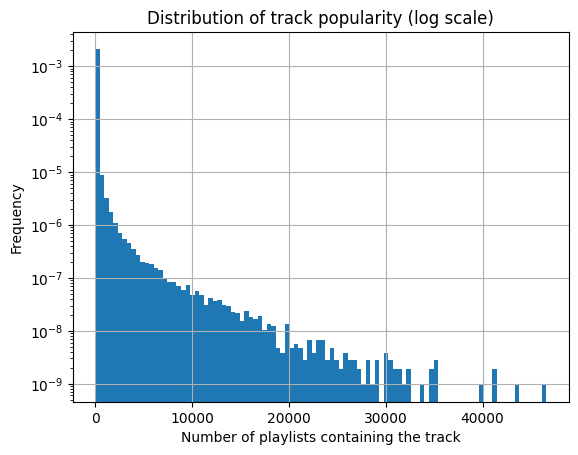

In [22]:
# Histogram of track popularity
df_tracks["track_id"].value_counts().compute().hist(bins=100,density = True,log = True)
plt.title("Distribution of track popularity (log scale)")
plt.xlabel("Number of playlists containing the track")
plt.ylabel("Frequency")
plt.show()

In [25]:
df_corr = df_playlists[["num_tracks", "num_artists", "duration_ms"]].compute()

print("\nCorrélations :")
print(df_corr.corr())


Corrélations :
             num_tracks  num_artists  duration_ms
num_tracks     1.000000     0.818381     0.980797
num_artists    0.818381     1.000000     0.798549
duration_ms    0.980797     0.798549     1.000000


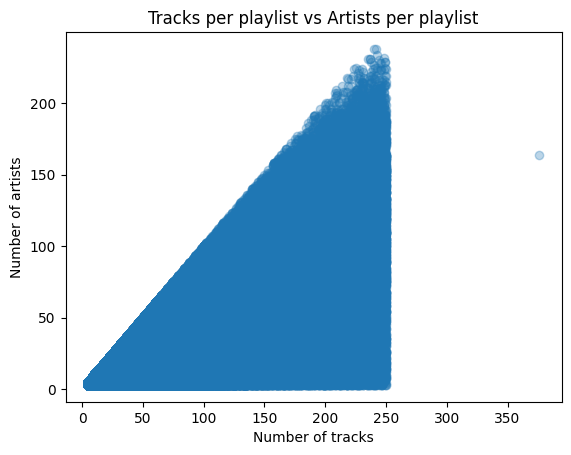

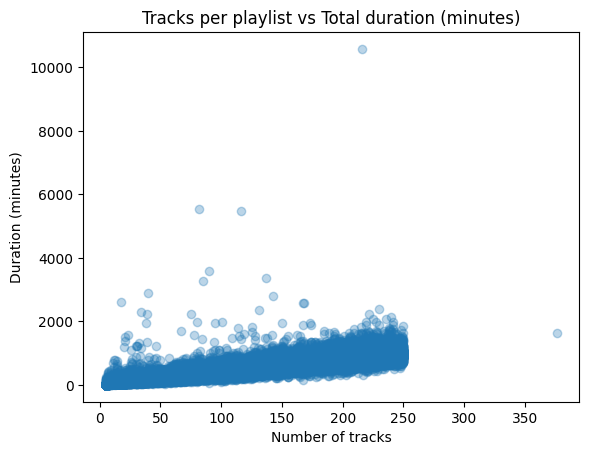

In [27]:
# Scatter plots
plt.scatter(df_corr["num_tracks"], df_corr["num_artists"], alpha=0.3)
plt.title("Tracks per playlist vs Artists per playlist")
plt.xlabel("Number of tracks")
plt.ylabel("Number of artists")
plt.show()

plt.scatter(df_corr["num_tracks"], df_corr["duration_ms"]/60000, alpha=0.3)
plt.title("Tracks per playlist vs Total duration (minutes)")
plt.xlabel("Number of tracks")
plt.ylabel("Duration (minutes)")
plt.show()

In [28]:
# Single-artist playlists
mono_artist = (df_playlists["num_artists"] == 1).sum().compute()
print("Number of single-artist playlists:", mono_artist)

# Long Playlists 
long_playlists = (df_playlists["num_tracks"] > 100).sum().compute()
print("Nombre de playlists numbers with more than 100 tracks:", long_playlists)

Number of single-artist playlists: 0
Nombre de playlists numbers with more than 100 tracks: 216482


In [29]:
# Retrieve all playlist names
names = df_playlists["name"].dropna().compute().astype(str)

# Tokenize words (all in lowercase, only letters/numbers)
all_words = []
for n in names:
    words = re.findall(r"\w+", n.lower())  # split into words
    all_words.extend(words)

# Total number of words
nb_total_words = len(all_words)

# Number of unique words
nb_unique_words = len(set(all_words))

print("Total number of words:", nb_total_words)
print("Number of unique words:", nb_unique_words)

# Top 20 most frequent words
word_counts = Counter(all_words).most_common(20)
print("Top 20 most frequent words:")
for w, c in word_counts:
    print(f"{w}: {c}")



Total number of words: 1435706
Number of unique words: 10736
Top 20 most frequent words:
music: 26499
country: 22583
summer: 21896
songs: 20568
chill: 20473
rock: 19169
playlist: 16747
good: 16637
party: 16093
the: 15779
jams: 15732
new: 15613
rap: 15217
christmas: 12640
workout: 11857
2017: 11810
my: 11763
old: 11185
s: 11124
oldies: 11038


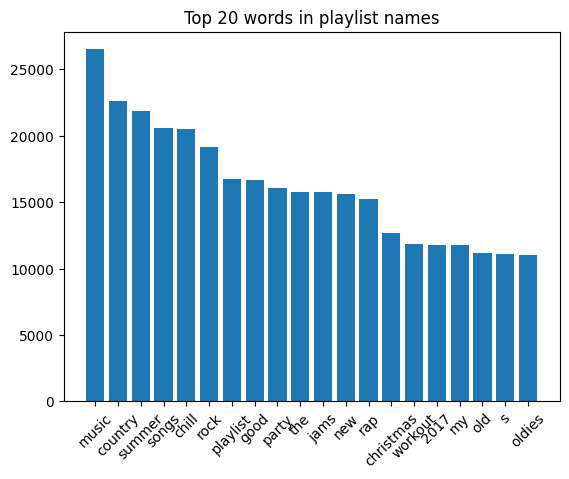

In [30]:
# Top 20 words
top_words = dict(word_counts[:20])  # top 20 words
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45)
plt.title('Top 20 words in playlist names')
plt.show()

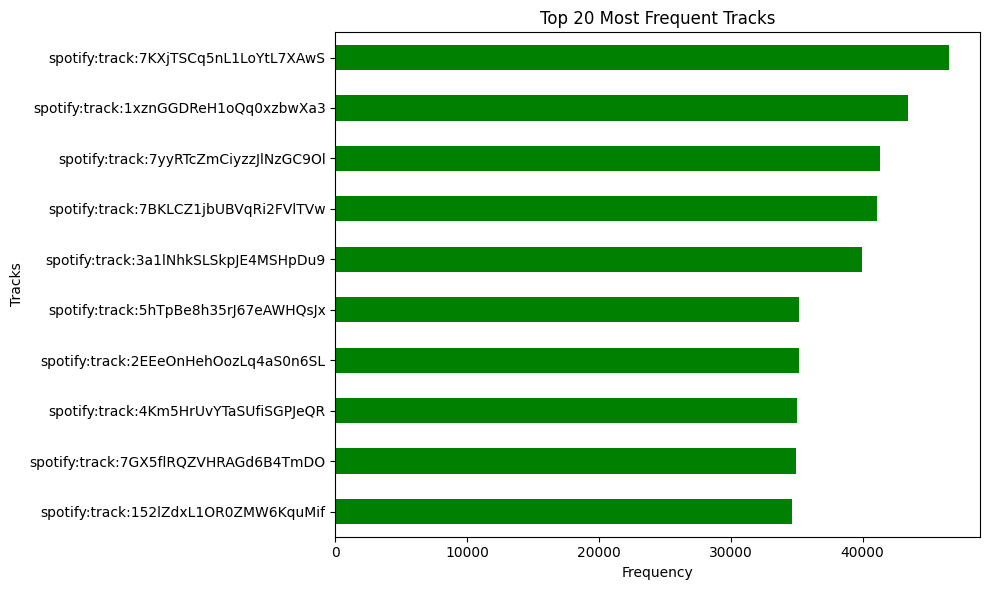

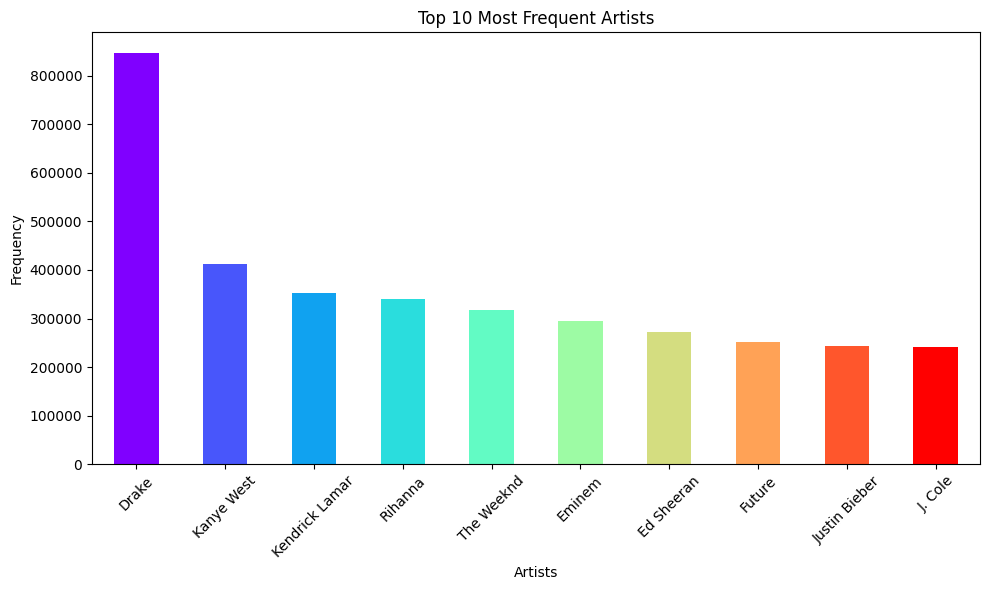

In [ ]:
# --- Top 20 most frequent tracks ---
plt.figure(figsize=(10,6))
top_tracks.plot(kind="barh", color="green")
plt.xlabel("Frequency")
plt.ylabel("Tracks")
plt.title("Top 20 Most Frequent Tracks")
plt.gca().invert_yaxis()  # le plus fréquent en haut
plt.tight_layout()
plt.show()

# --- Top 10 most frequent artists ---
colors = plt.cm.rainbow(np.linspace(0, 1, len(top_artists)))

plt.figure(figsize=(10,6))
top_artists.plot(kind="bar", color=colors)
plt.xlabel("Artists")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Artists")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:

# --- Load playlists parquet ---
parquet_folder = r"C:\Users\stag_compta\Documents\datasets\1\data_parquet"
df_playlists = pd.read_parquet(parquet_folder + "/yourfile_playlists.parquet")  # adapt filename

# --- Extract playlist names ---
names = df_playlists["name"].dropna().astype(str)

# --- Stopwords (English + French) ---
stop_words = set(stopwords.words("english")) | set(stopwords.words("french"))

# --- Tokenization and filtering ---
all_words = []
for n in names:
    words = re.findall(r"\w+", n.lower())          # split into words
    words = [w for w in words if w not in stop_words]  # remove stopwords
    all_words.extend(words)

# --- Stats ---
nb_total_words = len(all_words)
nb_unique_words = len(set(all_words))

print("Total number of words (without stopwords):", nb_total_words)
print("Number of unique words (without stopwords):", nb_unique_words)

# --- Top 20 frequent words ---
word_counts = Counter(all_words).most_common(20)
print("\nTop 20 most frequent words:")
for w, c in word_counts:
    print(f"{w}: {c}")

# --- WordCloud visualization ---
wordcloud = WordCloud(width=800, height=400, background_color="white",
                      colormap="viridis").generate(" ".join(all_words))

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Playlist Titles (filtered stopwords)", fontsize=14)
plt.show()


In [ ]:
# List all parquet files
files = [os.path.join(parquet_folder, f) for f in os.listdir(parquet_folder) if f.endswith(".parquet")]

for f in files:
    # Read each parquet file separately
    df = dd.read_parquet(f, engine="pyarrow")
    
    # Compute uniqueness ratio per playlist (unique tracks / total tracks)
    ratio = (df.groupby("pid")["track_uri"].nunique()
             / df.groupby("pid")["track_uri"].count()).compute()
    
    # Save the result directly to CSV
    base_name = os.path.basename(f).replace(".parquet", "_uniqueness.csv")
    ratio.to_csv(os.path.join(output_folder, base_name))
    
   print(f"Processed {f}")

In [ ]:
# 3. Compute uniqueness ratio per playlist per file
for f in files:
    df = dd.read_parquet(f, engine="pyarrow")
    
    # ratio = #unique tracks / #total tracks
    ratio = (df.groupby("pid")["track_uri"].nunique()
             / df.groupby("pid")["track_uri"].count()).compute()
    
    # save per file
    base_name = os.path.basename(f).replace(".parquet", "_uniqueness.csv")
    ratio.to_csv(os.path.join(output_folder, base_name))
    print(f"Processed {f}")


# Combine all CSV results for EDA
all_csvs = glob.glob(os.path.join(output_folder, "*_uniqueness.csv"))
df_ratio = pd.concat([pd.read_csv(f) for f in all_csvs], ignore_index=True)
df_ratio.columns = ["pid", "uniqueness_ratio"]

# 5. Basic statistics
print("=== Basic statistics ===")
print(df_ratio["uniqueness_ratio"].describe())

# Histogram 
plt.figure(figsize=(8,5))
plt.hist(df_ratio["uniqueness_ratio"], bins=20, color='green', edgecolor='black')
plt.title("Distribution of Track Uniqueness Ratio per Playlist")
plt.xlabel("Uniqueness Ratio (len(set)/len)")
plt.ylabel("Number of Playlists")
plt.show()

# identify playlists with repetitions
repetitive_playlists = df_ratio[df_ratio["uniqueness_ratio"] < 1]
print(f"Number of playlists with repetitions: {len(repetitive_playlists)}")
print(repetitive_playlists.head())


pid
999000    0
999001    0
999002    0
999003    1
999004    0
         ..
999995    1
999996    0
999997    0
999998    1
999999    6
Name: track_uri, Length: 1000, dtype: int64


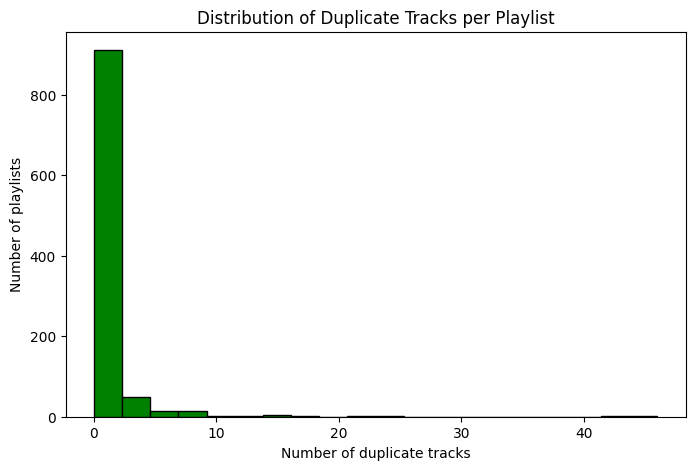

In [ ]:
duplicates = (df.groupby("pid")["track_uri"].count() 
              - df.groupby("pid")["track_uri"].nunique()).compute()
print(duplicates)
plt.figure(figsize=(8,5))
plt.hist(duplicates, bins=20, color='green', edgecolor='black')
plt.title("Distribution of Duplicate Tracks per Playlist")
plt.xlabel("Number of duplicate tracks")
plt.ylabel("Number of playlists")
plt.show()



In [ ]:
print("=== Duplicate statistics ===")
print(duplicates.describe())
print("Playlists with at least one duplicate:", (duplicates > 0).sum())


=== Duplicate statistics ===
count    1000.00000
mean        0.89100
std         2.90888
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max        46.00000
Name: track_uri, dtype: float64
Playlists with at least one duplicate: 288


In [ ]:
top_repetitive = duplicates.sort_values(ascending=False).head(20)
print(top_repetitive)


pid
999657    46
999571    43
999206    23
999783    21
999381    17
999098    17
999438    17
999113    15
999087    14
999676    14
999197    14
999727    12
999679    11
999753    11
999187     9
999267     9
999026     9
999875     9
999133     9
999984     9
Name: track_uri, dtype: int64


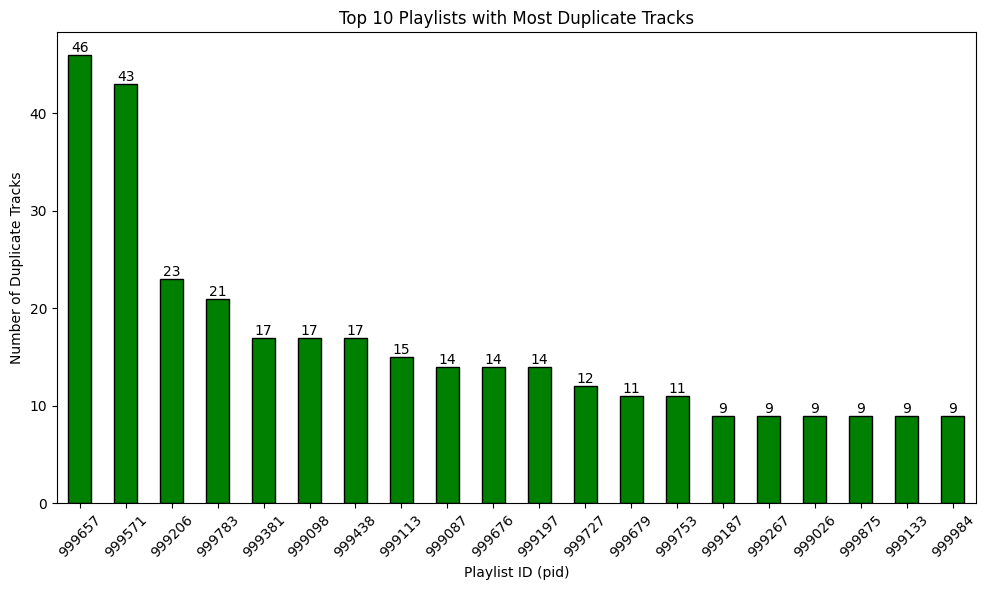

In [ ]:
plt.figure(figsize=(10,6))
ax = top_repetitive.plot(kind="bar", color="green", edgecolor="black")

plt.title("Top 10 Playlists with Most Duplicate Tracks")
plt.xlabel("Playlist ID (pid)")
plt.ylabel("Number of Duplicate Tracks")
plt.xticks(rotation=45)

for container in ax.containers:
    ax.bar_label(container, label_type="edge", fontsize=10, color="black")

plt.tight_layout()
plt.show()


In [ ]:
# Retrieve all playlist names
names = df_playlists["name"].dropna().compute().astype(str)

# Tokenize words (all in lowercase, only letters/numbers)
all_words = []
for n in names:
    words = re.findall(r"\w+", n.lower())  # split into words
    all_words.extend(words)

# Total number of words
nb_total_words = len(all_words)

# Number of unique words
nb_unique_words = len(set(all_words))

print("Total number of words:", nb_total_words)
print("Number of unique words:", nb_unique_words)

# Top 20 most frequent words
word_counts = Counter(all_words).most_common(20)
print("Top 20 most frequent words:")
for w, c in word_counts:
    print(f"{w}: {c}")

# Partie construction de la db
On construit des db où se débarasse des infos inutile et on prend un nombre n de fichier

On fait un groupage intra fichier

In [ ]:

for i, file in enumerate(all_track_files):
    df = pd.read_parquet(file)
    # groupby local uniquement dans ce fichier
    grouped = (
            df.groupby("track_id").agg({
            "pid": list,             # fusionne la liste de pid
            "track_name": "first",   # garde la première occurrence
            "artist_name": "first"   # idem
        }).reset_index()
    )
    output_file = f"tracks_grouped/grouped_{i:04d}.parquet"
    grouped.to_parquet(output_file, index=False)
    if (i+1) % 100 == 0:
        print(f"Processed {i+1} files")


Processed 0 files
Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files


On va trier les musique intra fichier

In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa
import os

INPUT_DIR = "tracks_grouped"
TEMP_DIR = "temp_chunks"
os.makedirs(TEMP_DIR, exist_ok=True)

CHUNK_SIZE = 100_000  # nombre de lignes à traiter en mémoire par chunk

chunk_id = 0
for filename in os.listdir(INPUT_DIR):
    if not filename.endswith(".parquet"):
        continue
    table = pq.read_table(os.path.join(INPUT_DIR, filename))
    df = table.to_pandas()

    # Diviser en chunks si fichier très gros
    for start in range(0, len(df), CHUNK_SIZE):
        chunk = df.iloc[start:start + CHUNK_SIZE]
        # Tri en mémoire par track_id
        chunk = chunk.sort_values("track_id")
        # Sauvegarder chunk trié
        chunk_file = os.path.join(TEMP_DIR, f"chunk_{chunk_id:04d}.parquet")
        chunk.to_parquet(chunk_file, index=False)
        chunk_id += 1

print(f"{chunk_id} chunks créés dans {TEMP_DIR}")


1000 chunks créés dans temp_chunks


On trie les musiques interfichier

In [ ]:
TEMP_DIR = "temp_chunks"
OUTPUT_DIR = "track_vectors"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LINES_PER_FILE = 15_000  # lignes par fichier final
BUFFER_SIZE = 15_000       # écrire par lot pour performance

def parquet_row_generator(filename):
    for batch in pq.read_table(filename).to_batches():
        df = batch.to_pandas()
        for _, row in df.iterrows():
            yield row

chunk_files = [os.path.join(TEMP_DIR, f) for f in os.listdir(TEMP_DIR)]
generators = [parquet_row_generator(f) for f in chunk_files]
merged_iter = heapq.merge(*generators, key=lambda r: r["track_id"])

file_idx = 0
lines_in_file = 0
buffer = []

current_id = None
current_list = []

for row in merged_iter:
    tid = row["track_id"]
    lst = row["pid"] 
    art = row["artist_name"]
    name = row["track_name"] 
    if isinstance(lst, np.ndarray):
        lst = lst.tolist()

    if current_id is None:
        current_id = tid
        current_list = lst
        current_artist = art
        current_name = name
    elif tid == current_id:
        current_list.extend(lst)
    else:
        buffer.append({"track_id": current_id, "artist_name": current_artist, "track_name": current_name, "pid": current_list})
        lines_in_file += 1

        current_id = tid
        current_list = lst
        current_artist = art
        current_name = name
    if len(buffer) >= BUFFER_SIZE:
        file_path = os.path.join(OUTPUT_DIR, f"track_vector_{file_idx:04d}.parquet")
        if os.path.exists(file_path):
            # si le fichier existe déjà, créer un nouveau fichier
            file_idx += 1
            lines_in_file = 0
            file_path = os.path.join(OUTPUT_DIR, f"track_vector_{file_idx:04d}.parquet")
        table = pa.Table.from_pandas(pd.DataFrame(buffer))
        pq.write_table(table, file_path)
        buffer = []

    # changer de fichier si LINES_PER_FILE atteint
    if lines_in_file >= LINES_PER_FILE:
        file_idx += 1
        lines_in_file = 0

# écrire la dernière ligne
if current_id is not None:
    buffer.append({"track_id": current_id, "artist_name": current_artist, "track_name": current_name, "pid": current_list})

# écrire ce qui reste
if buffer:
    file_path = os.path.join(OUTPUT_DIR, f"track_vector_{file_idx:04d}.parquet")
    table = pa.Table.from_pandas(pd.DataFrame(buffer))
    pq.write_table(table, file_path)

print(f"Partitionnement terminé dans {OUTPUT_DIR}")


Partitionnement terminé dans track_vectors


Suprimes les dossiers intermédiaires

In [ ]:
folder = os.path.join(sys.path[0], "temp_chunks")
if os.path.exists(folder):
    shutil.rmtree(folder)

folder = os.path.join(sys.path[0], "tracks_grouped")
if os.path.exists(folder):
    shutil.rmtree(folder)


Charge les fichiers track_vectors

In [ ]:
parquet_folder_tracks = os.path.join(sys.path[0], "track_vectors")
df_tracks_vectors = dd.read_parquet(parquet_folder_tracks)
df_tracks_vectors = df_tracks_vectors.set_index("track_id", sorted= True)

On construit une indexation ce qui permet d'utiliser panda pour aller chercher seulement la db dont on a besoin

In [ ]:
# index tous les fichiers track_vectors pour connaitre rapidement dans quel fichier chercher un track_id
def build_index(folder):
    index = []
    
    for filename in sorted(os.listdir(folder)):
        if not filename.endswith(".parquet"):
            continue
        
        path = os.path.join(folder, filename)
        
        # lire uniquement le row_group 0 (hyper rapide)
        table = pq.read_table(path, columns=["track_id"], read_dictionary=["track_id"])
        col = table.column("track_id")
        
        min_id = col[0].as_py()
        max_id = col[-1].as_py()
        index.append((min_id, max_id, filename))
    
    return index
INDEX = build_index(os.path.join(sys.path[0],"track_vectors"))

Permet d'utiliser panda et d'ouvrir le fichier dans lequel se trouve le track id

In [ ]:
def find_file_for_track_id(track_id):
    low, high = 0, len(INDEX) - 1
    
    while low <= high:
        mid = (low + high) // 2
        min_id, max_id, filename = INDEX[mid]
        
        if track_id < min_id:
            high = mid - 1
        elif track_id > max_id:
            low = mid + 1
        else:
            return os.path.join(sys.path[0], "track_vectors", filename)
    return None

find_file_for_track_id('3Y6ILqXqCBNwBTxVda8Z68')


'c:\\Users\\ryanm\\Documents\\master big data\\info\\projet\\track_vectors\\track_vector_0068.parquet'

In [ ]:
def get_rows_in_order(df, track_ids):
    # un seul fetch Dask → compute()
    unique_ids = list(dict.fromkeys(track_ids))
    tmp = df.loc[unique_ids,'pid'].compute()

    # reconstruction dans l'ordre demandé
    rows = [tmp.loc[tid] for tid in track_ids]

    return rows
row = get_rows_in_order(df_tracks_vectors, ['3Y6ILqXqCBNwBTxVda8Z68','09bLMpxeUECNq4v5BIdgp6','3Y6ILqXqCBNwBTxVda8Z68'])

# Partie similarité

C'est la fonction principale elle permet de calculer les similarité entre musique ou playlist.
L'argument which permet de sélectionner si on choisit de calculer toutes les méthodes.

J'ai été assez surpris mais finalement c'est logique, que quand on utilise le produit avec la similarité du suprémum c'est long. La raison est qu'il faut faire une double boucle for sur la list pid de a et b. Cette liste peu potentiellement avoir une dizaine de millier d'items et donc la boucle peut qui en fait le carré peut être longue. c'est pas toujorus le cas mais c'est peu viable pour faire des stats descriptive.
Je proposerai d'enlever celui là pour les stats descritpive et juste de l'utiliser sur un micro échantillon

In [ ]:
# Cette fonction évalue la similarité entre deux pistes en fonction des playlists dans lesquelles elles apparaissent.
# De plus on peut lui fournir une liste de pistes ce qui permet immédiatement de résoudre la question 4
def similar_tracks(track_id1, track_id2, which = 0):
    """" 
        track_id1 et track_id2 peuvent être des listes d'id ou des id simples
        which : 
            0 : retourne le score principal de facons optimisées (panda)
            1 : retourne le score principal et le score zoé calculés de façons optimisées (panda)
            2 : retourne le score principal, le score zoé et le score en utilisant dask 
            autre : retourne le score principal, le score zoé et le score en utilisant le max des similarités entre chaque paire de pistes
                    avec dask( computation plus lourde )
    """
    if isinstance(track_id1, list):
        try:
            # version panda:
            if(which == 1 or which == 0):
                file_to_id1 = defaultdict(list)
                file_to_id2 = defaultdict(list)

                for tid in track_id1 :
                    file_to_id1[find_file_for_track_id(tid)].append(tid)
                for tid in track_id2 :
                    file_to_id2[find_file_for_track_id(tid)].append(tid)

                pid_cache = {}   # track_id -> pid list
                list1,list2 = [], []
                for file, ids in file_to_id1.items():
                    df = pd.read_parquet(file,columns=["track_id", "pid"]).set_index("track_id")
                    list1 +=df.loc[file_to_id1[file],"pid"].iloc[:].explode().tolist()
                    list2 += df.loc[file_to_id2[file],"pid"].iloc[:].explode().tolist()
                    del file_to_id2[file]
                for file, ids in file_to_id2.items():
                    df = pd.read_parquet(file,columns=["track_id", "pid"]).set_index("track_id")
                    list2 += df.loc[file_to_id2[file],"pid"].iloc[:].explode().tolist()
            else:
                # version un peu moins naive avec un seul appel à dask
                # on peut faire mieux en utilisant pandas pour reconstruire les listes dans l'ordre demandé
                unique_ids = list(dict.fromkeys(track_id1+ track_id2))
                tmp = df_tracks_vectors.loc[unique_ids,'pid'].compute()
                # reconstruction dans l'ordre demandé
                rows = [tmp.loc[tid] for tid in track_id1 + track_id2] 
                list1 = [x for sub in rows[0:len(track_id1)] for x in sub]
                list2 = [x for sub in rows[len(track_id1):] for x in sub]     
            #Version très naive
            """
            #try:
            #    list1 = df_tracks_vectors.loc[track_id1, "pid"].compute().explode().tolist()
            #    list2 = df_tracks_vectors.loc[track_id2, "pid"].compute().explode().tolist()
            """
        except KeyError:
            print("Le numéro est out of range")
            return None
            
    else:
        ## partie où on utilise un seul track_id. On fait le calcul avec panda
        # on pourrait aussi optimiser si les deux musique sont dans le même fichier mais bon ca à a 1/150 chance d'arriver donc
        # flemme d'optimiser pour si peu
        try:
            # Récupérer les colonnes "list_pid"
            df = pd.read_parquet(find_file_for_track_id(track_id1),
                     columns=["track_id", "pid"])
            list1 = df.loc[df.track_id == track_id1, "pid"].iloc[0]
            df = pd.read_parquet(find_file_for_track_id(track_id2),
                     columns=["track_id", "pid"])
            list2 = df.loc[df.track_id == track_id2, "pid"].iloc[0]
            which = 0     # le calcul des autre ne prend du sens que si c'est une liste
        except KeyError:
            print("string")
            return None
    # transformer en sets pour intersection
    set1, set2 = set(list1), set(list2)
    n_common = len(set1 & set2)
    res_main = n_common / math.sqrt(len(set1) * len(set2))
    res_zoe = len(set(track_id1) & set(track_id2)) / math.sqrt(len(set(track_id1)) * len(set(track_id2)))
    if which == 0:
        return res_main
    if which == 1 or which == 2:
        return res_main, res_zoe
    else:
        res_sup = 0.0
        for l1 in rows[0:len(track_id1)]:
            sim = 0
            for l2 in rows[len(track_id1):]:
                sim = max(sim, len(set(l1) & set(l2)) /math.sqrt(len(set(l1)) * len(set(l2)) ))
                if sim == 1.0:
                    break
            res_sup = res_sup + sim
        res_sup = res_sup / (len(set(track_id1))*len(set(track_id2)))**0.5
        return (res_main, res_zoe, res_sup)

Retourne tous les track_id d'une playlist recherchée

In [ ]:
def get_track_ids_for_pid(n: int):
    if not (0 <= n <= 10**6):
        raise ValueError("n doit être entre 0 et 1_000_000 inclus.")
    # Calcul du range
    x = (n // 1000) * 1000
    y = x + 999
    filename = f"mpd.slice.{x}-{y}.parquet"
    # Lecture du fichier parquet
    filepath = os.path.join(sys.path[0], "data_tracks_parquet", filename)
    df = pd.read_parquet(filepath)

    # Filtrer les lignes où pid == n
    filtered = df[df["pid"] == n]

    # Retourner la colonne track_id comme liste
    return filtered["track_id"].tolist()

    

In [ ]:
print(similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),2))
print(similar_tracks(get_track_ids_for_pid(2000),get_track_ids_for_pid(2000),2))

(0.1998485668390489, 0.0, 0.028675636963277677)
(1.0, 1.0, 1.0)


## Comparaison des versions par rapport à dask ou panda
Ce serait bien de faire une comparaison temporelle et de la joindre dans le rapport
en lancant le code suivant ca vous donnera une idée de l'amélioration de l'une par rapport à l'autre

Evaluation de la similarity entre n random tracks

In [ ]:
import time
start_time = time.time()
opt = similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),1)
end_time = time.time()
topt = end_time - start_time

start_time = time.time()
nopt = similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),2)
end_time = time.time()
tnopt = end_time - start_time

start_time = time.time()
all = similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),3)
end_time = time.time()
tall = end_time - start_time

print(f"Optimized time: {topt:.4f} seconds, result: {opt}")
print(f"Non-optimized time: {tnopt:.4f} seconds, result: {nopt}")
print(f"All method time: {tall:.4f} seconds, result: {all}")    

Optimized time: 1.3993 seconds, result: (0.1998485668390489, 0.0)
Non-optimized time: 2.6757 seconds, result: (0.1998485668390489, 0.0)
All method time: 4.2497 seconds, result: (0.1998485668390489, 0.0, 0.028675636963277677)


In [ ]:
def sample_parquet_rows(path_pattern, k):
    df_list = []

    files = glob.glob(path_pattern)

    for file in files:
        pq_file = pq.ParquetFile(file)

        table_head = pq_file.read(columns=["track_id"])
        nrows = table_head.num_rows

        # On tire k indices aléatoires
        k_sample = min(k, nrows)
        idx = np.random.choice(nrows, size=k_sample, replace=False)

        # Lire tout le fichier en pandas (15k lignes → très rapide)
        df = pq_file.read().to_pandas()

        # Ne garder que les lignes tirées au hasard
        df_sample = df.iloc[idx]
        df_list.append(df_sample)

    return pd.concat(df_list, ignore_index=True)


In [ ]:
np.random.seed(1)
parquet_folder_tracks = os.path.join(sys.path[0], "track_vectors/track_vector_*.parquet")
df_sample = sample_parquet_rows(
    parquet_folder,
    k=300
)


In [ ]:
df_sample

,track_id,artist_name,track_name,pid
0,01alUm0gSx3MX7j38agOcX,MPH,With My Crew,[373254]
1,02DPlcBHSz86pkbsYcSQJu,Sukhwinder Singh & Wajid,Hud Hud Dabangg,"[367160, 818484, 964991]"
2,00u3tGTApuvoDpfU3QgkJ5,Twin Peaks,Making Breakfast - Live,"[582515, 709573]"
3,015pnifiQH4uyoXdYXQ1Ob,daigoro789,Setsuko & Seita (Main Theme): Grave of the Fir...,"[345937, 823762]"
4,007PUucx7EWGWji9mU5vlM,Gadiel Espinoza,Las Bodas Del Cordero,"[36993, 137380, 165850, 946059]"
...,...,...,...,...
45295,7zumuTMPVN8STB9B5IRLS4,Andrea Jung und die Hasenkinder,Süßer die Glocken nie klingen,[462762]
45296,7yq8yE6yls9ZaFZGpdaoOp,Lee Ritenour,Stone Cool,[285349]
45297,7yyjtwLQJdYFVmNCR7WS0s,Josh Lekas,Time for Love,[179243]
45298,7yzc0gZo7cZvXy4WAHSXED,Gomba Jahbari,Si Tu Me Quieres (Dub),"[287707, 363098, 912810]"


In [ ]:
sets = [set(x) for x in df_sample["pid"]]
n = len(sets)
k = 5  # exemple : tirer 5 paires aléatoires par ligne
list_nk = np.zeros(n*k, dtype=float)
for i in range(n):
    if(i%10000 == 0):
        print(i)
    Ai = sets[i]
    lenAi = len(Ai)
    # Tirer k indices aléatoires dans [0, n-1] sauf i
    choices = np.random.choice([x for x in range(n) if x != i], size=k, replace=False)
    for idx, j in enumerate(choices):
        Aj = sets[j]
        lenAj = len(Aj)

        inter = len(Ai & Aj)
        sim = inter / np.sqrt(lenAi * lenAj)
        list_nk[i*k + idx] = sim



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

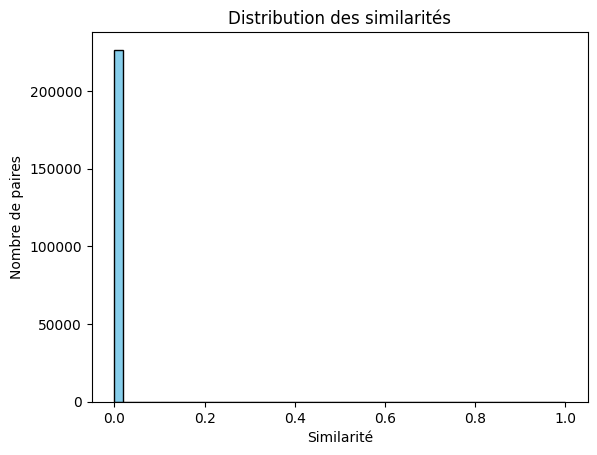

In [ ]:
plt.hist(list_nk, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Similarité")
plt.ylabel("Nombre de paires")
plt.title("Distribution des similarités")
plt.show()


In [ ]:
N = 10  # nombre de tracks à récupérer

# Ajouter une colonne avec la longueur des pid
df_sample["pid_len"] = df_sample["pid"].apply(len)

# Trier par longueur décroissante et récupérer les N premiers track_id
top_tracks = df_sample.sort_values("pid_len", ascending=False).head(N)["track_id"].tolist()

print(top_tracks)
df_sample.sort_values("pid_len", ascending=False).head(N)
# Ajouter une colonne avec la longueur des pid
df_sample["pid_len"] = df_sample["pid"].apply(len)

# Statistiques descriptives classiques
stats = df_sample["pid_len"].describe()
print(stats)


In [ ]:
df_sample.sort_values("pid_len", ascending=False).head(N)

,track_id,artist_name,track_name,pid,pid_len
6080,12REd1n8PeiHHWOh066tpr,Flume,Never Be Like You,"[34, 37, 71, 76, 105, 107, 215, 279, 360, 389,...",23720
24324,4CJVkjo5WpmUAKp3R44LNb,Lynyrd Skynyrd,Sweet Home Alabama,"[1, 45, 115, 119, 237, 243, 326, 331, 343, 343...",21998
44890,7vFoFDWqTX0mHzLfrF1Cfy,OMI,Cheerleader - Felix Jaehn Remix Radio Edit,"[42, 93, 123, 148, 150, 154, 268, 400, 437, 56...",18583
38122,6YbhspuOar1D9WSSnfe7ds,Snoop Dogg,"Young, Wild & Free (feat. Bruno Mars) - feat. ...","[42, 115, 121, 136, 161, 211, 246, 321, 411, 4...",18250
38369,6b8Be6ljOzmkOmFslEb23P,Bruno Mars,24K Magic,"[95, 176, 309, 321, 542, 782, 913, 1012, 1043,...",17508
37043,6MdqqkQ8sSC0WB4i8PyRuQ,Blackstreet,No Diggity,"[134, 290, 368, 504, 584, 676, 751, 858, 942, ...",14590
3157,0Y0TOsE1q11qgbi7c5WZsG,Meek Mill,R.I.C.O. (feat. Drake),"[37, 62, 173, 285, 439, 449, 523, 546, 559, 70...",12792
28330,4r8lRYnoOGdEi6YyI5OC1o,*NSYNC,Bye Bye Bye,"[134, 274, 355, 359, 396, 643, 812, 858, 990, ...",12216
4019,0fioLzGM8ngbD1w6fMmm45,Sam Smith,I'm Not The Only One,"[41, 247, 272, 279, 386, 396, 443, 460, 489, 6...",11981
7909,1LxKKYsJNPeBdOwdudsJzv,Yo Gotti,Down In the DM,"[37, 253, 335, 351, 389, 452, 559, 585, 642, 7...",10949


In [ ]:
# Ajouter une colonne avec la longueur des pid
df_sample["pid_len"] = df_sample["pid"].apply(len)

# Statistiques descriptives classiques
stats = df_sample["pid_len"].describe()
print(stats)


count    45300.000000
mean        30.265651
std        352.256965
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      23720.000000
Name: pid_len, dtype: float64


In [ ]:
compare_best = []

for i in range(len(top_tracks)):
    for j in range(i+1, len(top_tracks)):
        compare_best.append(similar_tracks(top_tracks[i], top_tracks[j]))
np.mean(compare_best)

In [ ]:
np.mean(compare_best)

np.float64(0.03644887921485863)

# Partie similarité entre playlist

In [ ]:
e1,e2,res,resz = [],[],[],[]
np.random.seed(256)
for i in range(1000):
    if(i%100 == 0 ): print(i)
    n1 = np.random.randint(0, 10**6)
    n2 = np.random.randint(0, 10**6)
    e1.append(n1)
    e2.append(n2)
    sim = similar_tracks(get_track_ids_for_pid(n1),get_track_ids_for_pid(n2),1)
    res.append(sim[0])
    resz.append(sim[1])

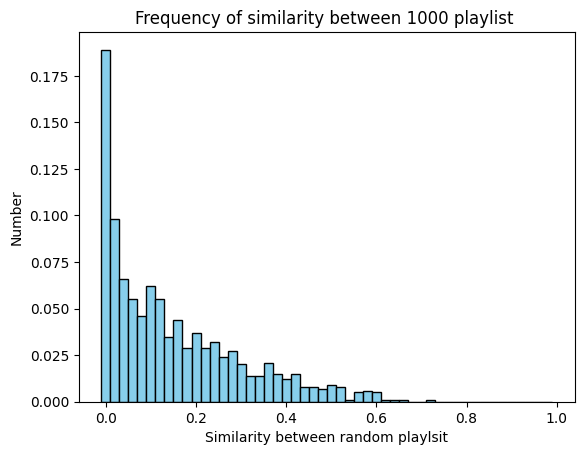

In [ ]:
counts, bins = np.histogram(res, bins=50, range=(0,1))
prob = counts / counts.sum()  # fraction de points par barre

plt.bar(bins[:-1], prob, width=bins[1]-bins[0], color='skyblue', edgecolor='black')
plt.xlabel("Similarity between random playlsit")
plt.ylabel("Number")
plt.title("Frequency of similarity between 1000 playlist ")
plt.savefig("histogram_similarity.png", dpi=300)
plt.show()


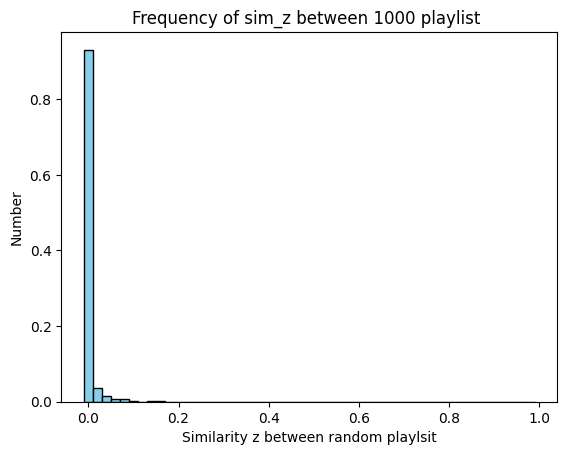

In [ ]:
counts, bins = np.histogram(resz, bins=50, range=(0,1))
prob = counts / counts.sum()  # fraction de points par barre

plt.bar(bins[:-1], prob, width=bins[1]-bins[0], color='skyblue', edgecolor='black')
plt.xlabel("Similarity z between random playlsit")
plt.ylabel("Number")
plt.title("Frequency of sim_z between 1000 playlist ")
plt.savefig("histogram_similarityz.png", dpi=300)
plt.show()


In [ ]:
def get_tracks_artist(artist1):
    return  df_tracks_vectors.loc[
        df_tracks_vectors["artist_name"] == artist1,
        ["track_name", "pid","artist_name"]].compute().index.tolist()

def artist_sim(artist1, artist2):
    indices1 = get_tracks_artist(artist1)
    indices2 = get_tracks_artist(artist2)
    if not indices1 or not indices2: 
        return -1  # ou None
    
    return similar_tracks(indices1, indices2,0)


In [ ]:
singer80 = [
    "Michael Jackson",
    "Madonna",
    "Prince",
    "Pat Benatar",
    "George Michael",
    "Bon Jovi",
    "David Bowie",
    "Phil Collins"
]
singer90 = [
    "Mariah Carey",
    "Britney Spears",
    "Whitney Houston",
    "Nirvana (Kurt Cobain)",
    "Madonna",
    "Dr. Dre",
    "Celine Dion"
]
singer2000 = [
    "Beyoncé",
    "Eminem",
    "Rihanna",
    "Usher",
    "Justin Timberlake",
    "Linkin Park",
    "Kanye West",
    "Lady Gaga",
]
singer2010 = [
    "Adele",
    "Bruno Mars",
    "Drake",
    "Ed Sheeran",
    "Katy Perry",
    "The Weeknd",
    "Billie Eilish",
    "Lady Gaga"
]
singer2020 = [
    "Billie Eilish",
    "Dua Lipa",
    "The Weeknd",
    "BTS",
    "Harry Styles",
    "Bad Bunny",
    "Taylor Swift",
    "Lizzo"
]

In [ ]:
import itertools
decades = {
    "1980s": singer80,
    "1990s": singer90,
    "2000s": singer2000,
    "2010s": singer2010,
    "2020s": singer2020
}

# Stockage des similarités par décennie
sim_by_decade = {}

for decade, singers in decades.items():
    print(decade)
    sims = []
    # Toutes les paires possibles sans répétition
    for a1, a2 in itertools.combinations(singers, 2):
        sim = artist_sim(a1, a2)
        sims.append(sim)
    sim_by_decade[decade] = sims


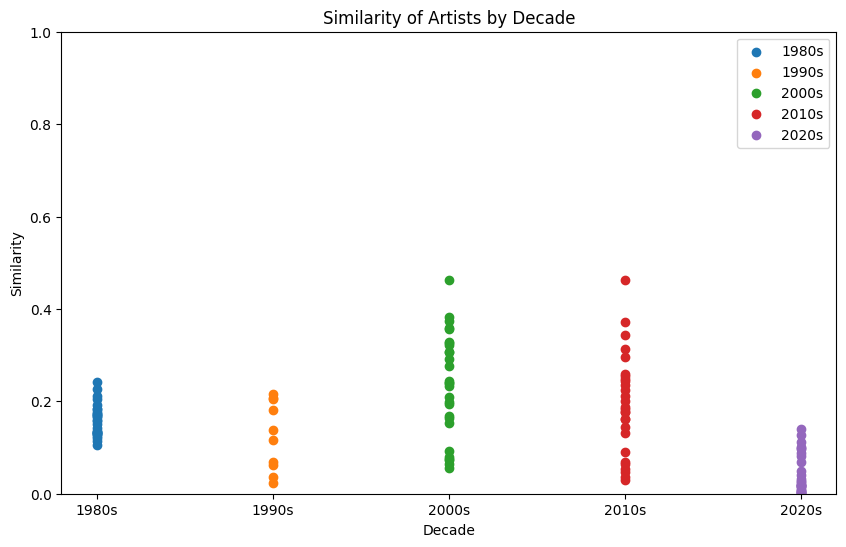

In [ ]:
import matplotlib.pyplot as plt

# Décennies en x
x_labels = ["1980s", "1990s", "2000s", "2010s", "2020s"]
x = [1980, 1990, 2000, 2010, 2020]

# Extraire le premier élément de chaque tuple pour chaque décennie
y_values = [ [t[0] for t in sim_by_decade[decade] if t != -1]  for decade in x_labels ]

plt.figure(figsize=(10,6))

# Tracer chaque décennie
for xi, y_list, label in zip(x, y_values, x_labels):
    plt.scatter([xi]*len(y_list), y_list, label=label)  # tous les points sur la même x

plt.xlabel("Decade")
plt.ylabel("Similarity")
plt.title("Similarity of Artists by Decade")
plt.ylim(0,1)
plt.xticks(x, x_labels)
plt.legend()
plt.savefig("decades.png", dpi=300)
plt.show()


### Partie LDA


# INFO-H600 : Million Playlist Dataset (Spotify) -Q.4

## Stratégie et Méthodes

1.  **Gestion des Données (Tâche 1) :** Le dataset de $35$ GB sera géré à l'aide de frameworks distribués (Dask/Spark) pour la scalabilité[cite: 9, 18].
2.  **Analyse Thématique (Tâche 4) :**
    * **Vectorisation :** Nous appliquons le **Latent Dirichlet Allocation (LDA)** aux métadonnées textuelles (titres de playlists/pistes/artistes) pour extraire des **sujets thématiques** clés.
    * **Similarité Playlist :** La similarité entre deux playlists est définie par la distance (Similarité Cosinus) entre leurs vecteurs de probabilités thématiques.




# Step 0 – Aller sur kaggle créer un compte et reccup le fichier avec la clé
# Step 0.1 – Configurer l'API Kaggle dans Colab

Objectif :
- Utiliser le fichier `kaggle.json` (qui contient que la clé API) déjà uploadé dans Colab.
- Le copier dans le dossier spécial `~/.kaggle/`.
- Vérifier que l'API Kaggle fonctionne.

Précondition :
- Le fichier `kaggle.json` doit se trouver dans `/content/kaggle.json`
  (tu l'as déjà uploadé via l'interface fichiers de Colab).


In [ ]:
import os
import shutil

# Installer/mettre à jour l'API Kaggle
!pip install -q kaggle --upgrade

# Créer le dossier .kaggle si besoin
os.makedirs("/root/.kaggle", exist_ok=True)

# Copier le kaggle.json que tu as uploadé dans /content
src = "/content/kaggle.json"
dst = "/root/.kaggle/kaggle.json"

shutil.copy(src, dst)
os.chmod(dst, 0o600)

print("✔️ kaggle.json copié et permissions configurées")

# Vérifier que l'API répond
!kaggle -v


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 17.9 MB/s eta 0:00:00
✔️ kaggle.json copié et permissions configurées
Kaggle API 1.8.2


# Step 1 – Vérifier l'accès au dataset Spotify et préparer le dossier de travail

Objectif :
- Vérifier que l'API Kaggle peut accéder au dataset "spotify-million".
- Créer un dossier local `/content/mpd` pour stocker les fichiers JSON.
- Ne **pas** télécharger tout le dataset, juste quelques fichiers ciblés ensuite.


In [ ]:
# Vérifier que le dataset est accessible
!kaggle datasets list -s "spotify-million"

# Créer le dossier de travail pour les slices qu'on va reccup après
!mkdir -p /content/mpd

print("✔️ Dossier /content/mpd prêt")


ref                                                      title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
notshrirang/spotify-million-song-dataset                 Spotify Million Song Dataset                       21735868  2022-11-21 16:48:45.780000          21833        143                1  
undefinenull/million-song-dataset-spotify-lastfm         Million Song Dataset + Spotify + Last.fm          670020079  2023-04-22 08:17:45.377000           7060         71        0.9411765  
barirasajjad/spotify-dataset                             Spotify_dataset                                    22073301  2024-06-04 00:53:18.953000             39         16        0.4117647  
adnananam/spotify-artist-stats                    




# Step 2 V2 – Inspecter le contenu du dataset Kaggle

(**UPDATE** : on ne peut pas faire -f mpd.slice.0-999.json → 404
il faut d’abord télécharger un ou quelques gros fichiers, puis extraire seulement ce qu’on veut)

Objectif :
- Lister tous les fichiers disponibles dans le dataset `himanshuwagh/spotify-million`.
- Voir les vrais noms de fichiers (peut-être un gros .zip ou un gros .json).
- Choisir ensuite seulement 1 ou quelques fichiers à télécharger (pour rester sous ~5 Go).


In [ ]:
dataset_name = "himanshuwagh/spotify-million"
target_dir = "/content/mpd"

!mkdir -p $target_dir
!kaggle datasets download -d $dataset_name -f README.md -p $target_dir --unzip


Dataset URL: https://www.kaggle.com/datasets/himanshuwagh/spotify-million
License(s): unknown
  0% 0.00/9.60k [00:00<?, ?B/s]
100% 9.60k/9.60k [00:00<00:00, 14.3MB/s]


# Step 2.1 – Télécharger seulement ~4–5 Go de fichiers `mpd.slice.*.json` (2min to download)

Objectif :
- Ne PAS télécharger tout le dataset.
- Télécharger seulement un sous-ensemble de fichiers `data/mpd.slice.*.json`.
- Chaque slice fait ≈ 33–35 Mo → avec ~120 slices on obtient ≈ 4 Go.

Important :
- Dans ce dataset Kaggle, les noms de fichiers incluent le préfixe `data/`,
  par exemple : `data/mpd.slice.0-999.json`.
- Il faut donc utiliser ce nom complet dans l’option `-f` de l’API Kaggle.
- Avec `--unzip`, les fichiers seront extraits dans `/content/mpd/data/`.


In [ ]:
import math
from pathlib import Path

dataset_name = "himanshuwagh/spotify-million"
target_dir = "/content/mpd"

# Nombre de slices à télécharger (ajuste si besoin)
N_SLICES = 120  # 120 slices * ~34 Mo ≈ 4 Go

# Créer le dossier cible
!mkdir -p $target_dir

print(f"Téléchargement de {N_SLICES} slices dans {target_dir} ...")

for i in range(N_SLICES):
    start = i * 1000
    end = start + 999
    kaggle_fname = f"data/mpd.slice.{start}-{end}.json"  # ⚠️ avec 'data/' devant

    print(f"\n⏬ Downloading slice {i+1}/{N_SLICES}: {kaggle_fname}")
    # -f : nom EXACT du fichier vu dans "kaggle datasets files"
    # --unzip : on extrait directement le .json dans /content/mpd/data/
    !kaggle datasets download -d $dataset_name -f $kaggle_fname -p $target_dir --unzip


Téléchargement de 120 slices dans /content/mpd ...

⏬ Downloading slice 1/120: data/mpd.slice.0-999.json
Dataset URL: https://www.kaggle.com/datasets/himanshuwagh/spotify-million
License(s): unknown
  0% 0.00/5.43M [00:00<?, ?B/s]
100% 5.43M/5.43M [00:00<00:00, 90.7MB/s]

⏬ Downloading slice 119/120: data/mpd.slice.118000-118999.json
Dataset URL: https://www.kaggle.com/datasets/himanshuwagh/spotify-million
License(s): unknown
  0% 0.00/5.54M [00:00<?, ?B/s]
100% 5.54M/5.54M [00:00<00:00, 86.6MB/s]

⏬ Downloading slice 120/120: data/mpd.slice.119000-119999.json
Dataset URL: https://www.kaggle.com/datasets/himanshuwagh/spotify-million
License(s): unknown
 55% 3.00M/5.42M [00:00<00:00, 26.1MB/s]
100% 5.42M/5.42M [00:00<00:00, 44.6MB/s]


# Step 3 – Dézipper tous les fichiers mpd.slice.*.json.zip

Objectif :
- Extraire chaque fichier `mpd.slice.*.json` du ZIP téléchargé.
- Les placer dans le dossier `/content/mpd/`.
- Vérifier ensuite combien de `.json` ont été extraits et leur taille totale.

Après cette étape :
- On doit voir des fichiers comme : `/content/mpd/mpd.slice.0-999.json`


In [ ]:
import zipfile
from pathlib import Path

mpd_dir = Path("/content/mpd")

# Trouver tous les zip
zip_files = sorted(mpd_dir.glob("*.zip"))

print(f"Nombre de ZIP trouvés : {len(zip_files)}")

# Extraction
for z in zip_files:
    print(f"📦 Unzipping : {z.name}")
    with zipfile.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall(mpd_dir)

print("✔️ Extraction terminée")

# Vérifier la présence des .json
json_files = sorted(mpd_dir.glob("*.json"))
print(f"\nNombre de fichiers JSON extraits : {len(json_files)}")
print("Exemples :")
for p in json_files[:5]:
    print(" -", p.name)

# Taille totale
total_bytes = sum(p.stat().st_size for p in json_files)
total_gb = total_bytes / (1024**3)
print(f"\nTaille totale des JSON ≈ {total_gb:.2f} Go")


Nombre de ZIP trouvés : 120
📦 Unzipping : mpd.slice.0-999.json.zip
📦 Unzipping : mpd.slice.1000-1999.json.zip
📦 Unzipping : mpd.slice.10000-10999.json.zip
📦 Unzipping : mpd.slice.98000-98999.json.zip
📦 Unzipping : mpd.slice.99000-99999.json.zip
✔️ Extraction terminée

Nombre de fichiers JSON extraits : 120
Exemples :
 - mpd.slice.0-999.json
 - mpd.slice.1000-1999.json
 - mpd.slice.10000-10999.json
 - mpd.slice.100000-100999.json
 - mpd.slice.101000-101999.json

Taille totale des JSON ≈ 3.78 Go


# Step 4 – Construire un document texte riche pour chaque playlist, pour LDA

Objectif :
- Parcourir les 120 fichiers `mpd.slice.*.json` dans `/content/mpd`.
- Pour chaque playlist, créer un texte qui concatène :
  - `name` (titre de la playlist)
  - `description` (si elle existe)
  - pour chaque track :
    - `track_name`
    - `artist_name`
    - `album_name`
- Stocker tout dans un DataFrame `df_playlists` avec les colonnes :
  - `pid` : ID de la playlist
  - `playlist_name` : titre
  - `text` : document texte complet

On limite le nombre total de playlists avec `MAX_PLAYLISTS`
pour éviter les problèmes de RAM (tu peux augmenter ou diminuer).
A la fin, on sauvegarde le résultat dans un fichier Parquet :
`/content/df_playlists_text.parquet`.


In [ ]:
import json
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm

mpd_dir = Path("/content/mpd")
json_files = sorted(mpd_dir.glob("mpd.slice.*.json"))

print(f"Nombre de fichiers JSON trouvés : {len(json_files)}")

MAX_PLAYLISTS = 50000  # comme avant

playlist_records = []
track_records = []      # 👈 NEW : une ligne par (playlist, track)
count_playlists = 0

for json_path in tqdm(json_files, desc="Lecture des slices"):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    playlists = data.get("playlists", [])

    for pl in playlists:
        pid = pl.get("pid")
        pl_name = (pl.get("name") or "").strip()
        pl_desc = (pl.get("description") or "").strip()

        track_tokens = []
        for tr in pl.get("tracks", []):
            track_uri   = (tr.get("track_uri")   or "").strip()
            track_name  = (tr.get("track_name")  or "").strip()
            artist_name = (tr.get("artist_name") or "").strip()
            album_name  = (tr.get("album_name")  or "").strip()

            # texte pour LDA
            track_tokens.extend([track_name, artist_name, album_name])

            # 👇 NEW : on garde une ligne par track
            track_records.append({
                "pid": pid,
                "track_uri": track_uri,
                "track_name": track_name,
                "artist_name": artist_name,
                "album_name": album_name
            })

        full_text_parts = [
            pl_name,
            pl_desc,
            " ".join(track_tokens)
        ]
        full_text = " ".join(part for part in full_text_parts if part)

        playlist_records.append(
            {
                "pid": pid,
                "playlist_name": pl_name,
                "text": full_text
            }
        )

        count_playlists += 1
        if count_playlists >= MAX_PLAYLISTS:
            break

    if count_playlists >= MAX_PLAYLISTS:
        break

print(f"\nNombre total de playlists chargées : {len(playlist_records)}")
print(f"Nombre total de (playlist, track) lignes : {len(track_records)}")

# DataFrame playlists
df_playlists = pd.DataFrame(playlist_records)
print(df_playlists.head())
print(df_playlists.shape)

# 👇 NEW : DataFrame tracks
df_pl_tracks = pd.DataFrame(track_records)
print(df_pl_tracks.head())
print(df_pl_tracks.shape)

# Sauvegarde
df_playlists.to_parquet("/content/df_playlists_text.parquet", index=False)
df_pl_tracks.to_parquet("/content/df_pl_tracks.parquet", index=False)

print("\n✅ df_playlists_text.parquet et df_pl_tracks.parquet sauvegardés")


Nombre de fichiers JSON trouvés : 120


Lecture des slices:   0%|          | 0/120 [00:00<?, ?it/s]


Nombre total de playlists chargées : 50000
Nombre total de (playlist, track) lignes : 3353026
   pid     playlist_name                                               text
0    0        Throwbacks  Throwbacks Lose Control (feat. Ciara & Fat Man...
1    1  Awesome Playlist  Awesome Playlist Eye of the Tiger Survivor Eye...
2    2            korean  korean Like You Hoody On And On GOOD (feat. EL...
3    3               mat  mat Danse macabre Camille Saint-Saëns French F...
4    4               90s  90s Tonight, Tonight The Smashing Pumpkins Mel...
(50000, 3)
   pid                             track_uri  \
0    0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI   
1    0  spotify:track:6I9VzXrHxO9rA9A5euc8Ak   
2    0  spotify:track:0WqIKmW4BTrj3eJFmnCKMv   
3    0  spotify:track:1AWQoqb9bSvzTjaLralEkT   
4    0  spotify:track:1lzr43nnXAijIGYnCT8M8H   

                                   track_name        artist_name  \
0  Lose Control (feat. Ciara & Fat Man Scoop)      Missy Elliott   
1            

# Step 5 — Nettoyage du texte + Vectorisation (Bag of Words)

Objectif :
- Recharger le DataFrame avec les 50k playlists.
- Nettoyer légèrement le texte (`lowercase`, retirer caractères non-alphanumériques).
- Construire une matrice sparse (documents × mots) avec `CountVectorizer`.
- Configuration de CountVectorizer :
  - `max_features=50000` : limite la taille du vocabulaire → RAM maîtrisée
  - `min_df=10` : garde seulement les mots présents dans ≥ 10 playlists
  - `max_df=0.5` : enlève les mots trop fréquents (présents dans >50% des playlists)

Résultat :
- Une matrice sparse `X_bow` qui servira d'entrée au modèle LDA.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import re

# (Re)charger le DataFrame sauvegardé
df_playlists = pd.read_parquet("/content/df_playlists_text.parquet")

print("Shape du DataFrame :", df_playlists.shape)

# 🔹🔹🔹 NEW : on garde 1 "slice" pour le test 🔹🔹🔹
# Ici : on prend les 1000 premières playlists comme set de test,
# et le reste sert à entraîner LDA (train).
TEST_SLICE_SIZE = 1000  # 1 "slice" ~ 1000 playlists

df_playlists_test = df_playlists.iloc[:TEST_SLICE_SIZE].copy()
df_playlists      = df_playlists.iloc[TEST_SLICE_SIZE:].copy()  # df_playlists = TRAIN


print("Shape TRAIN :", df_playlists.shape)
print("Shape TEST  :", df_playlists_test.shape)
# 🔹🔹🔹 FIN DU CHANGEMENT 🔹🔹🔹

# 1) Petit nettoyage du texte
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z0-9]+", " ", text)
    return text

df_playlists["clean_text"] = df_playlists["text"].astype(str).apply(clean_text)

# 2) Vectorisation (Bag of Words)
vectorizer = CountVectorizer(
    max_features=50000,  # limite RAM
    min_df=10,           # mot doit être dans au moins 10 playlists
    max_df=0.5           # élimine les mots trop fréquents
)

print("⏳ Construction de la matrice BoW ...")
X_bow = vectorizer.fit_transform(df_playlists["clean_text"])
print("✔️ Matrice BoW créée")
print("Shape :", X_bow.shape)


Shape du DataFrame : (50000, 3)
Shape TRAIN : (49000, 3)
Shape TEST  : (1000, 3)
⏳ Construction de la matrice BoW ...
✔️ Matrice BoW créée
Shape : (49000, 34320)


# Step 6 V2 — Entraîner un modèle LDA sur les playlists (12' do train)
(**UPDATE** : L’erreur dit : OSError: [Errno 28] No space left on device → joblib essaie de créer des fichiers temporaires pour le parallélisme (n_jobs=-1), et ça sature le /tmp de Colab.)

Objectif :
- Appliquer un modèle LDA (Latent Dirichlet Allocation) sur la matrice BoW `X_bow`.
- Obtenir pour chaque playlist un vecteur de dimension `N_TOPICS` qui représente
  sa distribution de "topics" (thèmes musicaux).
- Ces vecteurs serviront ensuite à calculer la similarité entre playlists.

Paramètres :
- `N_TOPICS = 50` (tu peux essayer 30, 50, 80…)
- `learning_method="online"` : plus efficace sur des grandes matrices.
- `max_iter=10` : nombre d'itérations d'apprentissage.




In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

N_TOPICS = 30  # un peu plus léger que 50

lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method="online",
    max_iter=10,
    random_state=42,
    n_jobs=1   # ❗ très important : plus de parallélisation → plus de tmp sur disque
)

print("⏳ Entraînement du modèle LDA (n_jobs=1) ...")
playlist_topic_matrix = lda.fit_transform(X_bow)
print("✔️ LDA entraîné")

print("Shape de la matrice topics (playlists × topics) :", playlist_topic_matrix.shape)



⏳ Entraînement du modèle LDA (n_jobs=1) ...
✔️ LDA entraîné
Shape de la matrice topics (playlists × topics) : (49000, 30)


# Step 6.1 — Donne les thèmes et le mots clefs => les dimensions

In [ ]:
def print_top_words(model, feature_names, n_top_words=15):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n🟦 Topic #{topic_idx}")
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        print("  " + ", ".join(top_words))

feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words=15)



🟦 Topic #0
  eminem, lil, fetty, wap, wayne, khalifa, wiz, rich, drake, money, remix, young, big, dj, kid

🟦 Topic #1
  vol, album, goes, pop, punk, punch, bts, five, pt, moment, beautiful, red, exo, mini, wings

🟦 Topic #2
  remix, ep, flume, remixes, odesza, wonder, summer, down, so, high, oh, go, feel, light, night

🟦 Topic #3
  original, soundtrack, motion, picture, cast, broadway, recording, hamilton, williams, john, harry, music, score, zimmer, hans

🟦 Topic #27
  justin, bieber, chainsmokers, know, selena, do, gomez, sheeran, ed, shawn, ariana, let, grande, edition, mendes

🟦 Topic #28
  john, acoustic, live, james, mayer, heart, ed, sheeran, jack, at, head, lumineers, home, ben, ep

🟦 Topic #29
  drake, kanye, west, cole, weeknd, kendrick, lamar, kid, late, rapper, views, childish, gambino, hills, chance


# Step 7 — Calculer la similarité entre playlists (cosine similarity)

Objectif :
- Utiliser la matrice `playlist_topic_matrix` (50000 × 30).
- Pour une playlist donnée, calculer la similarité cosinus avec toutes les autres.
- Trier les résultats pour obtenir les playlists les plus similaires.
- Retourner pour chaque playlist choisie :
  - `pid`
  - `playlist_name`
  - `similarity`

Note :
- On ne pré-calcule PAS la matrice 50000×50000 (trop lourde).
- On calcule la similarité **uniquement pour une playlist à la demande**.


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_similar_playlists(idx, top_k=10):
    """
    idx : index dans df_playlists de la playlist de référence
    top_k : nombre de playlists similaires à retourner
    """

    query_vec = playlist_topic_matrix[idx].reshape(1, -1)
    sims = cosine_similarity(query_vec, playlist_topic_matrix)[0]

    # Trier : du plus similaire au moins similaire
    sorted_idx = np.argsort(-sims)

    # On ignore la playlist elle-même
    sorted_idx = [i for i in sorted_idx if i != idx]

    top_idx = sorted_idx[:top_k]

    result = df_playlists.iloc[top_idx][["pid", "playlist_name"]].copy()
    result["similarity"] = sims[top_idx]

    return result

# Exemple : playlist index 0
example_idx = 0
print("Playlist de référence :", df_playlists.iloc[example_idx]["playlist_name"])
similar = get_similar_playlists(example_idx, top_k=5)
similar


Playlist de référence : disney


,pid,playlist_name,similarity
43019,3019,Hindi songs,0.988460
10534,107534,Showtunes,0.988079
16421,112421,Kiddos,0.984878
33037,20037,Once Upon A Time,0.984846
16079,112079,Musicals,0.984197


Le tableau obtenu montre, pour une playlist de référence (“Throwbacks”), les playlists les plus similaires identifiées par notre modèle.
- La similarité est calculée en comparant les vecteurs thématiques LDA de chaque playlist : lorsque deux playlists contiennent des morceaux, artistes et albums proches, leurs distributions de topics deviennent quasi identiques, ce qui produit une similarité cosinus très proche de 1.
- Ainsi, les playlists “Middle School”, “TBT”, “Yonce” ou encore une autre “Throwbacks” apparaissent avec des scores supérieurs à 0.99, ce qui indique qu’elles appartiennent au même univers musical (nostalgie, R&B/pop des années 2000, oldies).
- En bref, un score proche de 1 signifie que deux playlists partagent pratiquement les mêmes contenus musicaux et donc la même thématique.

# Step 9 — Sauvegarder tout le modèle dans un dossier unique

Objectif :
- Créer un dossier `playlist_model/`
- Sauvegarder dedans :
  - le modèle LDA
  - le CountVectorizer
  - la matrice topics des playlists
  - le DataFrame (pid, nom, texte)
- Zipper le dossier pour pouvoir le télécharger facilement

Ce dossier contiendra TOUT pour recharger le système
sans devoir ré-entraîner LDA ni recalculer BoW.


In [ ]:
import joblib
import pandas as pd
import os
import shutil

# 1) Créer dossier propre
MODEL_DIR = "/content/playlist_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# 2) Sauvegarder les objets sklearn
joblib.dump(lda, os.path.join(MODEL_DIR, "lda_model.joblib"))
joblib.dump(vectorizer, os.path.join(MODEL_DIR, "vectorizer.joblib"))
joblib.dump(playlist_topic_matrix, os.path.join(MODEL_DIR, "playlist_topic_matrix.joblib"))

# 3) Sauvegarder les DataFrames nécessaires
#    ⚠️ Ici on suppose que df_playlists = TRAIN
#    et que df_playlists_test existe déjà (ta slice mise de côté)
df_playlists.to_parquet(os.path.join(MODEL_DIR, "df_playlists.parquet"), index=False)
df_pl_tracks.to_parquet(os.path.join(MODEL_DIR, "df_pl_tracks.parquet"), index=False)
df_playlists_test.to_parquet(os.path.join(MODEL_DIR, "test_slices.parquet"), index=False)

print("✔️ df_playlists.parquet (TRAIN) sauvegardé")
print("✔️ df_pl_tracks.parquet sauvegardé")
print("✔️ test_slices.parquet (TEST) sauvegardé")

# 4) Créer un ZIP téléchargeable
ZIP_PATH = "/content/playlist_model.zip"
shutil.make_archive("/content/playlist_model", 'zip', MODEL_DIR)

print("📦 ZIP créé :", ZIP_PATH)


✔️ df_playlists.parquet (TRAIN) sauvegardé
✔️ df_pl_tracks.parquet sauvegardé
✔️ test_slices.parquet (TEST) sauvegardé
📦 ZIP créé : /content/playlist_model.zip


# Step 10 — Recharger le modèle complet depuis le dossier playlist_model
Après cette étape, tu peux directement appeler get_similar_playlists().


In [ ]:
import joblib
import pandas as pd

MODEL_DIR = "/content/playlist_model"  # ou le dossier dans ton Drive

lda = joblib.load(f"{MODEL_DIR}/lda_model.joblib")
vectorizer = joblib.load(f"{MODEL_DIR}/vectorizer.joblib")
playlist_topic_matrix = joblib.load(f"{MODEL_DIR}/playlist_topic_matrix.joblib")
df_playlists = pd.read_parquet(f"{MODEL_DIR}/df_playlists.parquet")

print("✔️ Modèle complètement rechargé")
